In [5]:
%matplotlib inline
from sklearn.decomposition import PCA
import sys
sys.path.append("../")
import scvi
from smFISH.dataset import CortexDataset, SmfishDataset
from scvi.inference import VariationalInferenceFish
from scvi.models import VAEF
from scvi.metrics.clustering import get_data, get_common_t_sne
from smFISH.metrics.visualisation import show_cell_types, show_mixing, compare_cell_types, show_gene_exp, show_spatial_expression
from scvi.metrics.classification import compute_accuracy_nn, compute_accuracy_svc
from scvi.metrics.imputation import proximity_imputation, get_index, plot_imputation
import numpy as np


# Creating and training the model

In [7]:
genes_to_discard = ['gad2', 'sox10']
gene_dataset_fish = SmfishDataset()
gene_names = gene_dataset_fish.gene_names
l = []
for n_gene in range(len(gene_names)):
    for gene in genes_to_discard:
        if gene_names[n_gene].lower() == gene.lower():
            l.append(n_gene)
genes_to_discard = l
indexes_to_keep = np.arange(len(gene_names))
indexes_to_keep = np.delete(indexes_to_keep, genes_to_discard)
# The "genes_to_discard" argument is given here so that the order of the genes in CortexDataset matches
# the order in SmfishDataset

File data/osmFISH_SScortex_mouse_all_cell.loom already downloaded
Preprocessing smFISH dataset
Finished preprocessing smFISH dataset


 We run with 50 additional genes for the scRNA-seq dataset

In [46]:
gene_dataset_seq = CortexDataset(genes_fish=gene_dataset_fish.gene_names, 
                                 genes_to_keep=["mog", "sst", "gja1", "ctss", "ndnf"], additional_genes=50)

File data/expression.bin already downloaded
Preprocessing Cortex data
Finished preprocessing Cortex data


In [47]:
vae = VAEF(gene_dataset_seq.nb_genes, indexes_to_keep, n_layers_decoder=2, n_latent=6,
           n_layers=2, n_hidden=256, reconstruction_loss='nb', dropout_rate=0.3, n_labels=7, n_batch=0, model_library=False)
infer = VariationalInferenceFish(vae, gene_dataset_seq, gene_dataset_fish, train_size=0.9, verbose=True, frequency=5, weight_decay=0.35, n_epochs_even=100, n_epochs_kl=1000,
                                cl_ratio = 0, n_epochs_cl=100)
infer.train(n_epochs=250, lr=0.0008)
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']



EPOCH [0/250]: 
LL for train_seq is : 378.4297
LL for test_seq is : 376.0593
LL for train_fish is : 215.8230
LL for test_fish is : 233.2658

EPOCH [5/250]: 
LL for train_seq is : 297.6938
LL for test_seq is : 293.7947
LL for train_fish is : 126.0498
LL for test_fish is : 124.8796

EPOCH [10/250]: 
LL for train_seq is : 261.0479
LL for test_seq is : 256.7385
LL for train_fish is : 107.9701
LL for test_fish is : 106.2227

EPOCH [15/250]: 
LL for train_seq is : 238.3984
LL for test_seq is : 235.3543
LL for train_fish is : 102.3772
LL for test_fish is : 101.8606

EPOCH [20/250]: 
LL for train_seq is : 226.5280
LL for test_seq is : 224.9595
LL for train_fish is : 95.2856
LL for test_fish is : 94.0306

EPOCH [25/250]: 
LL for train_seq is : 220.4883
LL for test_seq is : 219.1731
LL for train_fish is : 93.4914
LL for test_fish is : 91.4843

EPOCH [30/250]: 
LL for train_seq is : 216.7705
LL for test_seq is : 213.4043
LL for train_fish is : 91.4539
LL for test_fish is : 89.4942

EPOCH [35/250

In [48]:
data_loader_fish = infer.data_loaders['train_fish']
data_loader_seq = infer.data_loaders['train_seq']
# Getting data of interest
latent_seq, _, labels_seq, expected_frequencies_seq, values_seq = get_data(vae, data_loader_seq, mode="scRNA")
latent_fish, _, labels_fish, expected_frequencies_fish, values_fish, x_coords, y_coords = get_data(vae, data_loader_fish, mode="smFISH")

In [49]:
# Getting data for benchmark
concatenated_matrix = np.concatenate((gene_dataset_fish.X[:, vae.indexes_to_keep], gene_dataset_seq.X[:, vae.indexes_to_keep]))
concatenated_matrix = np.log(1 + concatenated_matrix)
PCA_labels = gene_dataset_fish.labels.ravel()
PCA_labels_reg = gene_dataset_seq.labels.ravel()
pca = PCA(n_components=9)
latent_pca = pca.fit_transform(concatenated_matrix)
PCA_latent_fish = latent_pca[:gene_dataset_fish.X.shape[0], :]
PCA_latent_seq = latent_pca[gene_dataset_fish.X.shape[0]:, :]
PCA_values_seq = gene_dataset_seq.X
PCA_values_fish = gene_dataset_fish.X
PCA_labels_seq = gene_dataset_seq.labels
PCA_labels_fish = gene_dataset_fish.labels

# 1. Imputation

In [50]:
imputed = expected_frequencies_fish[:, 0] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)


In [51]:
idx_gad = get_index(gene_dataset_seq.gene_names, "gad2")
idx_sox = get_index(gene_dataset_seq.gene_names, "sox10")

Found idx 0 for gene gad2!
Found idx 17 for gene sox10!


## Imputing missing gene GAD2: our method vs baseline

In [52]:
imputed = expected_frequencies_fish[:, idx_gad] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
mean = np.mean(values_fish[:, idx_gad])
# to_keep = [idx for idx in range(len(values_fish[:, 0])) if values_fish[idx, 0]<mean]
plot_imputation(np.log(1+imputed), np.log(1+values_fish[:, idx_gad]))
# plot_imputation(imputed[to_keep], values_fish[to_keep, 0]) # zooming on the highest density region


<Figure size 432x288 with 0 Axes>

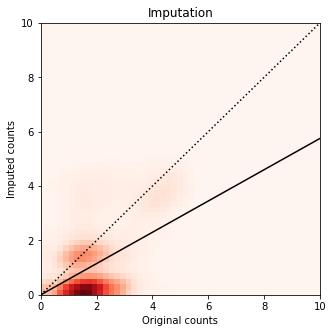

<Figure size 432x288 with 0 Axes>

In [53]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_gad], PCA_latent_fish, k=5)

# plot_correlation(PCA_values_fish[:, 0], predicted_PCA)
mean = np.mean(PCA_values_fish[:, idx_gad])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_gad])) if PCA_values_fish[idx, 0]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_gad]))
# plot_imputation(predicted_PCA[to_keep], PCA_values_fish[to_keep, 0]) # zooming on the highest density region

## Imputing missing gene SOX10: our method vs baseline

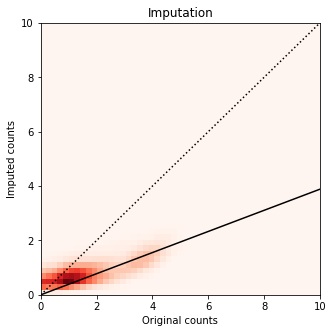

<Figure size 432x288 with 0 Axes>

In [54]:
imputed = expected_frequencies_fish[:, idx_sox] 
imputed = imputed / np.sum(expected_frequencies_fish[:, vae.indexes_to_keep], axis=1).ravel()
imputed *= np.sum(values_fish[:, vae.indexes_to_keep], axis=1)
mean = np.mean(values_fish[:, idx_sox])
# to_keep = [idx for idx in range(len(values_fish[:, 0])) if values_fish[idx, 0]<mean]
plot_imputation(np.log(1+imputed), np.log(1+values_fish[:, idx_sox]))

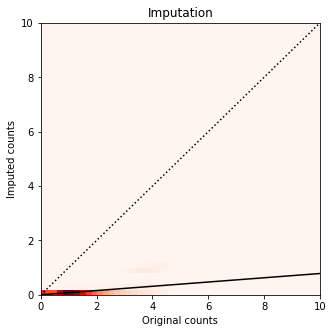

<Figure size 432x288 with 0 Axes>

In [55]:
predicted_PCA = proximity_imputation(PCA_latent_seq, PCA_values_seq[:, idx_sox], PCA_latent_fish, k=5)

# plot_correlation(PCA_values_fish[:, 0], predicted_PCA)
mean = np.mean(PCA_values_fish[:, idx_sox])
to_keep = [idx for idx in range(len(PCA_values_fish[:, idx_sox])) if PCA_values_fish[idx, idx_sox]<mean]
plot_imputation(np.log(1+predicted_PCA), np.log(1+PCA_values_fish[:, idx_sox]))
# plot_imputation(predicted_PCA[to_keep], PCA_values_fish[to_keep, idx_actb]) # zooming on the highest density region

# 2. Getting a common meaningful representation

In [56]:
t_sne_seq, t_sne_fish, idx_t_sne_seq, idx_t_sne_fish = get_common_t_sne(latent_seq, latent_fish, n_samples=1000)


## Our method: Embedding of the two datasets in the shared latent space

In [57]:
show_cell_types(t_sne_seq, labels_seq[idx_t_sne_seq], t_sne_fish, labels_fish[idx_t_sne_fish])


<Figure size 432x288 with 0 Axes>

## Benchmark: Embedding of the two datasets in the shared latent space

In [147]:
show_cell_types(PCA_latent_seq[:, :2], PCA_labels_seq.ravel(), PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), x_lim=None)


<Figure size 432x288 with 0 Axes>

## How well do the datasets mix in the latent space?

In [58]:
show_mixing(t_sne_seq, t_sne_fish)
print(entropy_batch_mixing(np.concatenate((t_sne_seq, t_sne_fish)),
                           batches=np.concatenate((np.zeros_like(idx_t_sne_seq),
                                                  np.ones_like(idx_t_sne_fish)))))

0.5643622882149897


<Figure size 432x288 with 0 Axes>

In [149]:
show_mixing(PCA_latent_seq[:, :2], PCA_latent_fish[:, :2], x_lim=None)
print(entropy_batch_mixing(np.concatenate((PCA_latent_seq[:, :2], PCA_latent_fish[:, :2])),
                           batches=np.concatenate((np.zeros_like(PCA_latent_seq[:, :2]),
                                                  np.ones_like(PCA_latent_fish[:, :2])))))

0.11706162181452962


<Figure size 432x288 with 0 Axes>

## Is the data structure conserved in the latent space?

We plot the values of expected frequencies of marker genes for sub-cell types for scRNA-seq data. If cells with high values for those genes are grouped together, it means that the structure at the sub-cell-type scale is conserved within the latent space

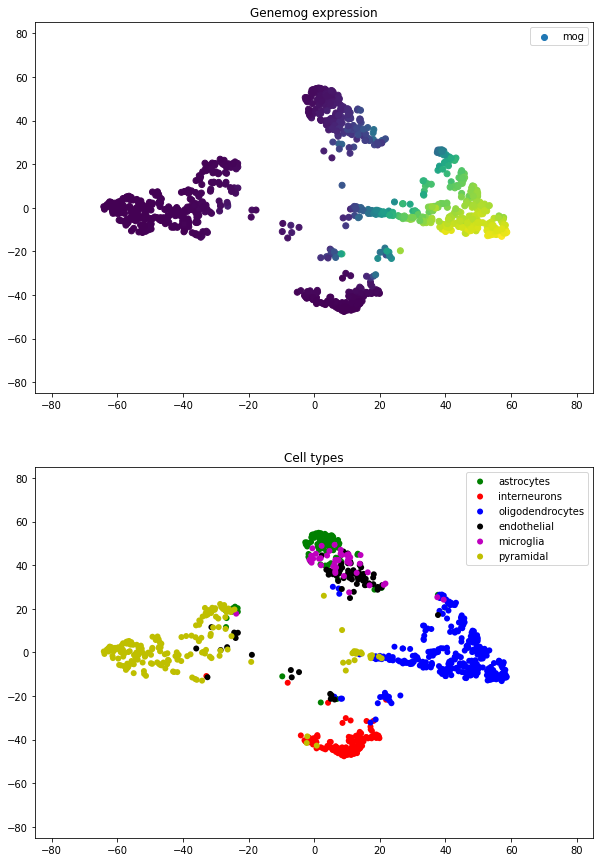

<Figure size 432x288 with 0 Axes>

In [73]:
show_gene_exp(t_sne_seq, expected_frequencies_seq[idx_t_sne_seq, idx_oligo], labels=labels_seq[idx_t_sne_seq],
              title="latent_exp_inter_seq.svg", gene_name="mog")

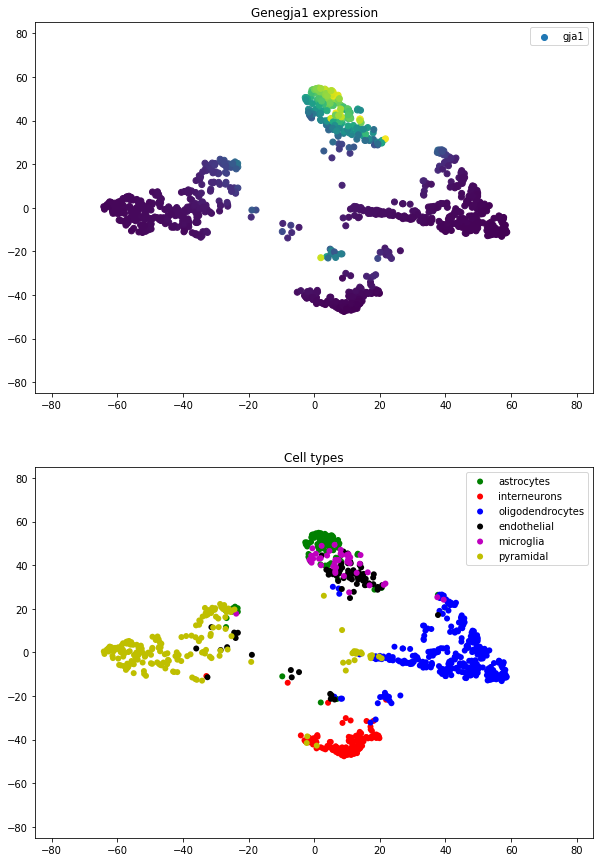

<Figure size 432x288 with 0 Axes>

In [74]:
show_gene_exp(t_sne_seq, expected_frequencies_seq[idx_t_sne_seq, idx_astro], labels=labels_seq[idx_t_sne_seq],
              title="latent_exp_astro_seq.svg", gene_name="gja1")

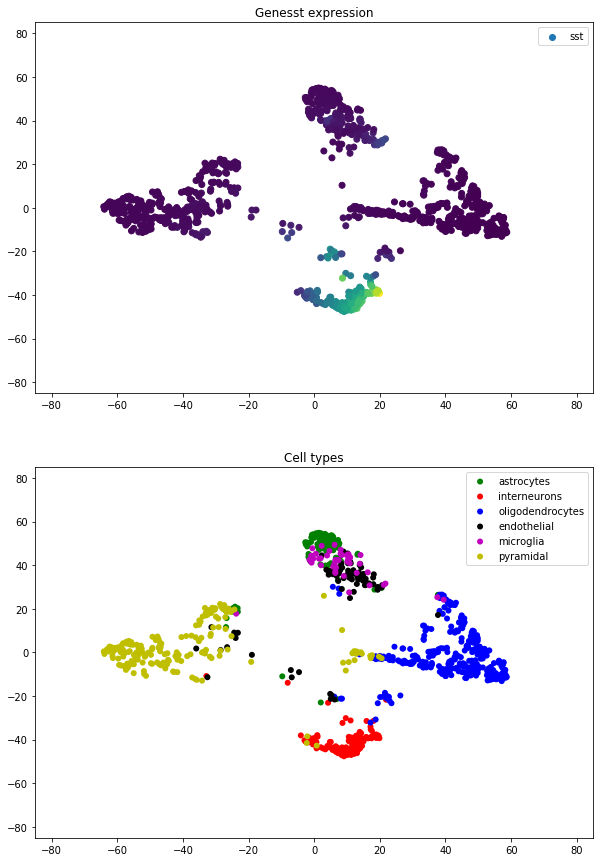

<Figure size 432x288 with 0 Axes>

In [75]:
show_gene_exp(t_sne_seq, expected_frequencies_seq[idx_t_sne_seq, idx_interneurons], labels=labels_seq[idx_t_sne_seq],
              title="latent_exp_inter_seq.svg", gene_name="sst")

# 3. Classifying cells in different cell types

In [60]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def cluster_svc(frequencies1, label1, frequencies2):
    svc = SVC()
    parameters = {'kernel':('linear', 'rbf'), 'C': [1, 100]}
    clf = GridSearchCV(svc, parameters)
    clf.fit(frequencies1, label1)
    inferred_labels = clf.predict(frequencies2)
    return inferred_labels


def cluster_accuracy_svc(frequencies1, label1, frequencies2, label2):
    inferred_labels = cluster_svc(frequencies1, label1, frequencies2)
    for label in range(inferred_labels.shape[0]):
        if inferred_labels[label] == 6:
            inferred_labels[label] = 5
    clustering_accuracy = np.mean(inferred_labels == label2)*100
    return clustering_accuracy, inferred_labels


In [62]:
accuracy_svc, inferred_labels_svc = cluster_accuracy_svc(expected_frequencies_seq, labels_seq, expected_frequencies_fish, labels_fish)
_, PCA_accuracy, PCA_inferred_labels = compute_accuracy_nn(PCA_latent_seq, PCA_labels_seq.ravel(), PCA_latent_fish, PCA_labels_fish.ravel())


Accuracy and PCA_accuracy: KNN classifier based on our latent space and the baseline's latent space.                    
Accuracy_svc: obtained using a SVC classifier trained on the predicted expected frequencies for the counts 

In [63]:
print(PCA_accuracy)
print(accuracy_svc)

Accuracy(unweighted=0.20797848498431198, weighted=0.2603256481888458, worst=0.08045977011494253, accuracy_classes=[0.6055045871559633, 0.10034602076124567, 0.5571245186136072, 0.10236220472440945, 0.08045977011494253, 0.1161567877629063])
67.14819427148194


## Inferred vs real labels

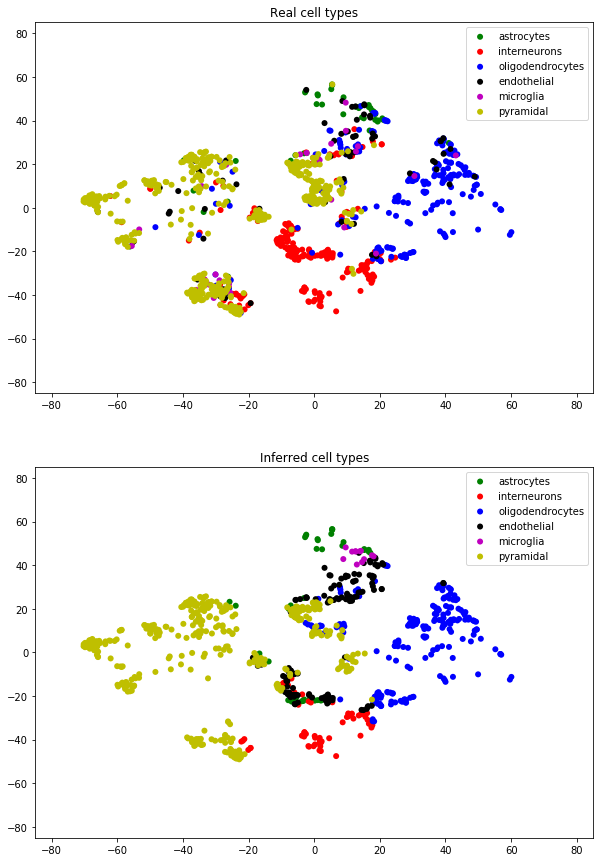

<Figure size 432x288 with 0 Axes>

In [68]:
compare_cell_types(t_sne_fish, labels_fish[idx_t_sne_fish], inferred_labels_svc[idx_t_sne_fish])


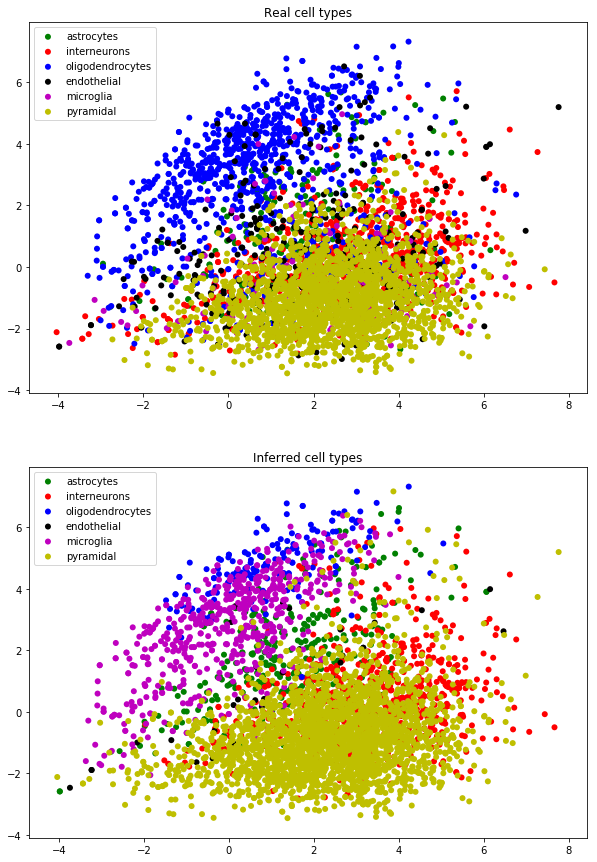

<Figure size 432x288 with 0 Axes>

In [157]:
compare_cell_types(PCA_latent_fish[:, :2], PCA_labels_fish.ravel(), PCA_inferred_labels, x_lim=None)


# 4. Going further: Imputing unobserved genes for the smFISH experiment

We impute marker genes for different cell types, to ensure the consistency of our model

In [69]:
idx_astro = get_index(gene_dataset_seq.gene_names, "gja1")
idx_oligo = get_index(gene_dataset_seq.gene_names, "mog")
idx_interneurons = get_index(gene_dataset_seq.gene_names, "sst")

Found idx 80 for gene gja1!
Found idx 66 for gene mog!
Found idx 37 for gene sst!


## Astrocytes marker gene imputation

In [191]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_astro], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_astro.svg", gene_name="gja1")

<Figure size 432x288 with 0 Axes>

## Oligodendrocytes marker gene imputation
This marker gene defines a finer cell type within the astrocytes population. Here, we see a clear gradient of expression for this gene.   

Imputation of refined cell types marker gene is a feature that could help us get a more precise spatial map of cell types 

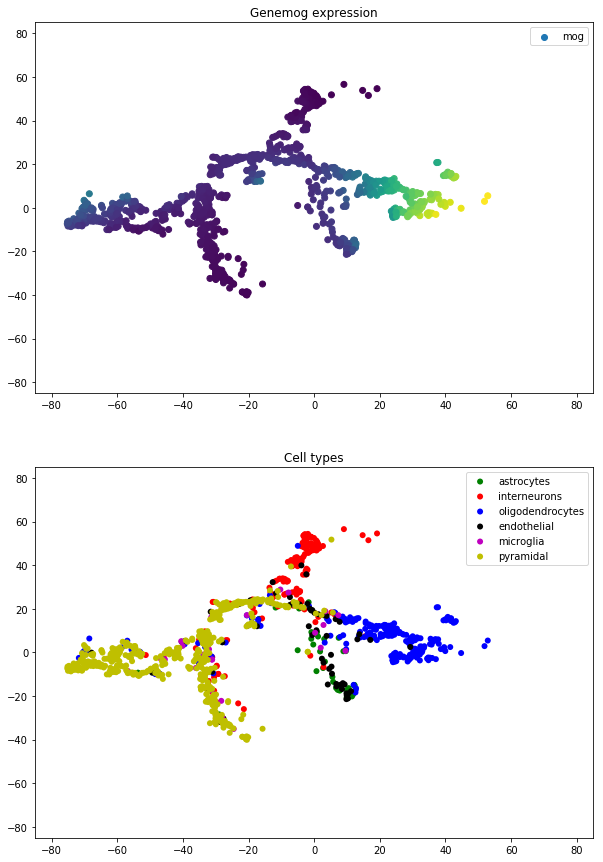

<Figure size 432x288 with 0 Axes>

In [192]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_oligo], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_oligo.svg", gene_name="mog")

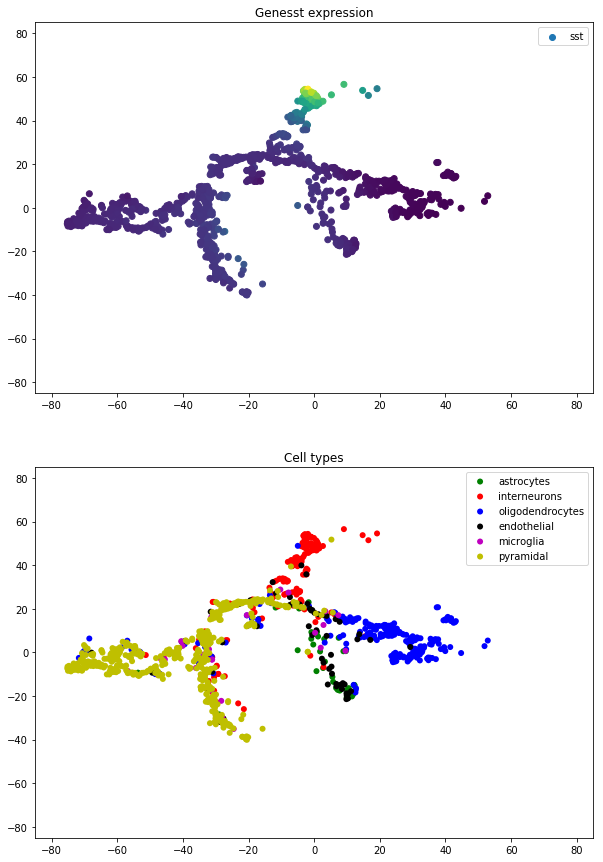

<Figure size 432x288 with 0 Axes>

In [193]:
show_gene_exp(t_sne_fish, expected_frequencies_fish[idx_t_sne_fish, idx_interneurons], labels=labels_fish[idx_t_sne_fish],
              title="latent_exp_interneurons.svg", gene_name="sst")

## Spatial imputation

Now that we can impute values for smFISH cells, we can estimate a spatial map for the gene expression of genes sequenced with scRNA-seq

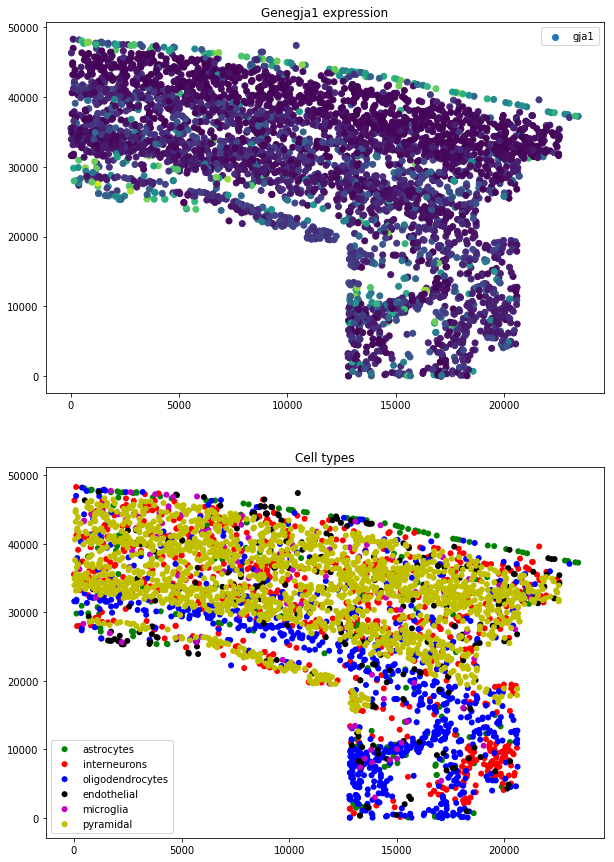

<Figure size 432x288 with 0 Axes>

In [76]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_astro], labels=labels_fish,
                        title="spatial_exp_astro.svg", gene_name="gja1")

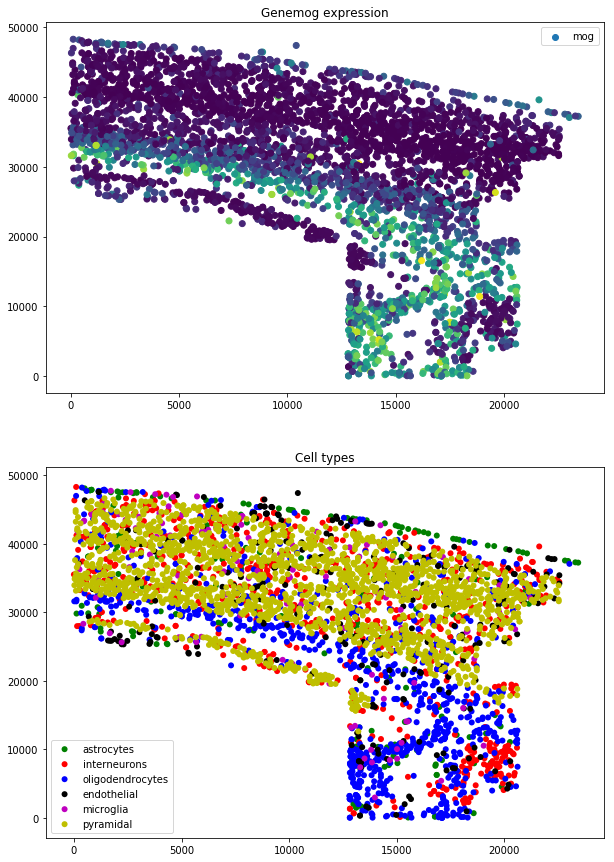

<Figure size 432x288 with 0 Axes>

In [77]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_oligo], labels=labels_fish,
                        title="spatial_exp_oligo.svg", gene_name="mog")

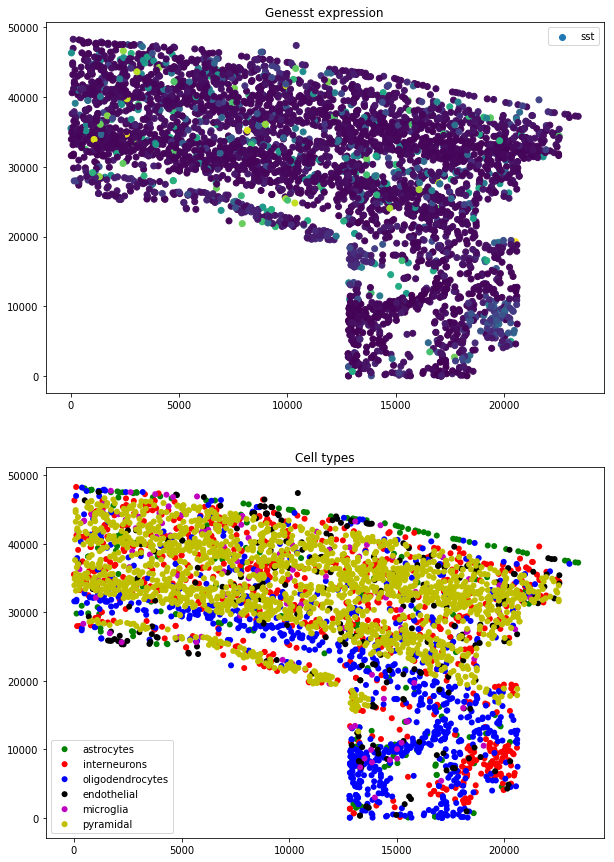

<Figure size 432x288 with 0 Axes>

In [78]:
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_interneurons],
                        labels=labels_fish, title="spatial_exp_interneurons.svg", gene_name="sst")

## Finding spatially differentialy expressed genes

In [82]:
idx_meg3 = 45
show_spatial_expression(x_coords, y_coords,
                        expected_frequencies_fish[:, idx_meg3],
                        labels=labels_fish, title="spatial_exp_interneurons.svg", gene_name="sst")

<Figure size 432x288 with 0 Axes>